In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, QTable, join

import thejoker as tj
import pymc as pm
import corner
import arviz as az
import astropy.units as u
from astropy.time import Time

In [2]:
apogee_gold  = Table.read("../../lithium/cosmic/apogee_goldsample.fits")
apw_binaries = Table.read('../../lithium/cosmic/apw_binaries.fits')


In [3]:
apogee_dr16_visit = Table.read('../files/apogee_dr16_allVisit-r12-l33.fits')
apogee_dr16_visit.convert_bytestring_to_unicode()


In [4]:
apogee_dr16 = Table.read('../../lithium/data/allStarLite-r12-l33.fits')
apogee_dr16.convert_bytestring_to_unicode()
apogee_dr16 = apogee_dr16[(apogee_dr16['TEFF']>0) & (apogee_dr16['LOGG']>-9000.) ]


In [5]:
galah_mag_lower, galah_mag_upper = 7.456999778747559, 11.829999923706055
mag_lower, mag_upper = 7,12
apogee_rg = apogee_dr16[(apogee_dr16['TEFF']<=5730) & (apogee_dr16['TEFF']>=3000) & 
                        (apogee_dr16['LOGG']<=3.2) & (apogee_dr16['LOGG']>=-1) & 
                        (apogee_dr16['NVISITS']>=4) &
                        (apogee_dr16['WASH_DDO51_GIANT_FLAG']==1) & 
                        (apogee_dr16['J']>=mag_lower) & (apogee_dr16['J']<=mag_upper) 
                        
                       ]
len(apogee_rg)

4363

In [6]:
len(apogee_dr16_visit)

1778792

In [7]:
mask = np.isin(apogee_dr16_visit['APOGEE_ID'], apogee_rg['APOGEE_ID'])

apogee_dr16_visit = apogee_dr16_visit[mask]

In [8]:
apogee_cut  = apogee_rg.copy()
apogee_cut2 = apogee_dr16_visit.copy()

# merged = join(apogee_cut, apogee_cut2, keys='APOGEE_ID')


In [9]:

keep_star = []
for i in apogee_cut:
    starflag   = str(i['STARFLAG'])
    aspcapflag = str(i['ASPCAPFLAG'])
    
    if '3' not in starflag and '16' not in starflag and '16' not in aspcapflag \
    and '17' not in aspcapflag and '18' not in aspcapflag and '26' not in aspcapflag and '30' not in aspcapflag:
        keep_star.append(i['APOGEE_ID'])
        
mask = np.isin(apogee_cut['APOGEE_ID'], keep_star)

apogee_rg_good = apogee_cut[mask]


In [10]:
keep_visit = []
for i in apogee_cut2:
    starflag = str(i['STARFLAG'])
    visit_id = i['VISIT_ID']
    if '3' not in starflag and '9' not in starflag and '12' not in starflag and '13' not in starflag and '16' not in starflag:
        keep_visit.append(visit_id)

mask = np.isin(apogee_cut2['VISIT_ID'], keep_visit)
apogee_visit_good = apogee_cut2[mask]


In [11]:
merged = join(apogee_rg_good, apogee_visit_good, keys='APOGEE_ID', join_type='left')

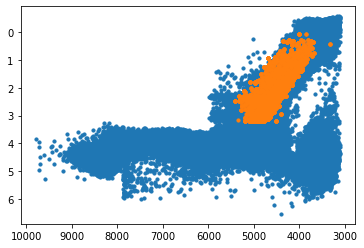

In [12]:
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'],s=10)
plt.scatter(merged['TEFF'],merged['LOGG'],s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [13]:
def run_joker(data,Pi,Pf,K0=20, max_posterior=1000, error=0.1,prior_size=1_000_000):#,save=False,MCMC=False):
    time, rv, err = data[0], data[1], data[2]
    err            = np.array(err)
    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data           = Table()
    data['bmjd']   = time
    data['rv']     = rv
    data['rv_err'] = err

    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bmjd"], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v=100*u.km/u.s,            
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    
    joker = tj.TheJoker(prior, rng=rnd)


    #print('running joker for posterior samples...')
    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=max_posterior,
                                           return_all_logprobs=True)
    print('# of joker samples returned second round:',len(joker_samples[0]))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            ax=ax,
        )
    return joker_samples
    

In [14]:
merged[merged['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR']]

# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR','STARFLAGS']]

JD,VHELIO,VRELERR
float64,float32,float32


In [15]:

unique_apogee_id = list(set(merged['APOGEE_ID']))
print('# of unique RGs:',len(unique_apogee_id))
import glob
done = glob.glob('apogee_reference_samples/*.npy')
done = [i.split('/')[-1] for i in done]
done = [i.split('.npy')[0] for i in done]
done = list(set(done))

print('done',len(done))
print(len(set(unique_apogee_id)))
print(len(list(set(unique_apogee_id) - set(done))))

# of unique RGs: 3632
done 1274
3632
2707


In [ ]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    unique_apogee_id = list(set(unique_apogee_id) - set(done))
    
    for i,star in enumerate(unique_apogee_id):
        
        if i<637: continue
        print(i, star)
        dtemp   = merged[merged['APOGEE_ID'] == star]
        if len(dtemp) == 1 and dtemp.has_masked_values is True:
            print('\t','masked content.')
            continue

        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time    = dtemp['JD'].value
        
        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time = Time(time, format="jd", scale="tcb")
        time = time.mjd

        data = [time, rv_vals, err]
        data = np.array(data)
        np.save('apogee_reference_samples/%s.npy'%star, data )
        
        joker_samples = run_joker(data, Pi=1, Pf=3000)
        save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
        joker_samples[0].write(save_dir, overwrite=True)
        print('\n')
        
pipeline()


# of unique RGs: 3632
637 2M14303512+5134215
# of joker samples returned second round: 1000


638 2M16051405-1003394
# of joker samples returned second round: 1000


639 2M17213669+4404593
# of joker samples returned second round: 1000


640 2M15025493+3630249
# of joker samples returned second round: 1000


641 2M21341525+1050120
# of joker samples returned second round: 1000


642 2M16283303-1341545
	 masked content.
643 2M11430424+2651479


In [ ]:
def checking():
    
    files = glob.glob('apogee_reference_samples/*.hdf5')
    
    x = []
    
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if name in unique_apogee_id:
            samples = tj.JokerSamples.read(file)
            x.append(len(samples))
    x=np.array(x)
    print(len(x))
    print(len(x[x>256]))
#     plt.hist(x,bins='auto')
checking()

In [ ]:
def reload(name):

    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    data    = np.load('apogee_reference_samples/%s.npy'%name)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    t = Time(data[0], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data[1]*u.km/u.s, rv_err=data[2]*u.km/u.s)
    
    _ = tj.plot_rv_curves(
            samples[0:100],
            data=data,
            ax=ax,
        )

reload('2M07370225+2201156')

In [ ]:
tj.JokerSamples.read('apogee_reference_samples/2M07370225+2201156.hdf5')#['P']

In [ ]:
ss

In [ ]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    
    new_df = {'APOGEE_ID':[],
              'semi_amp': [],
              'logg': [],
              'deltat': []
             }
    
    
    for i,star in enumerate(unique_apogee_id):
        print(i, star)

        dtemp = merged[merged['APOGEE_ID'] == star]
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time = dtemp['JD']
        time = Time(time, format="jd", scale="tcb")
        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time   = time.mjd
        if len(rv_vals) < 1: continue
        
        semi_k = (max(rv_vals) - min(rv_vals))*0.5
        log_g  = dtemp['LOGG'][0]
#         print(log_g, semi_k)
        new_df['APOGEE_ID'].append(star)
        new_df['semi_amp'].append(semi_k)
        new_df['logg'].append(log_g)
        new_df['deltat'].append(max(time)-min(time))
    return new_df  
        
#         data = [time, rv_vals, err]
#         data = np.array(data)
#         np.max()
#         np.save('apogee_reference_samples/%s.npy'%star, data )
        
#         joker_samples = run_joker(data, Pi=1, Pf=3000)
#         save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
#         joker_samples[0].write(save_dir, overwrite=True)
        #print('\n')
      
new_df = pipeline()
        

In [ ]:
def func1(logg):
    a, b = -0.60, 3.31
    log_v = a*logg+b
    return 10.**log_v
    
def func2(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func3(logg):
    siga, sigb = -0.04, -0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func4(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+1.5*siga
    b = b+1.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
    

In [ ]:
merged.keys()

In [ ]:
new_df_2 = pd.DataFrame(new_df)
new_df_2['exp_amp'] = func2(new_df_2['logg'])/1000.# func2()/1000.

mask = (new_df_2['semi_amp'] >= new_df_2['exp_amp'])

# PLOTTING
plt.figure(dpi=100)
xvals = np.linspace(0.5,3.5,1000)
plt.scatter(new_df_2['logg'], new_df_2['semi_amp'],label='red giants with N>4 visits')
plt.scatter(new_df_2[mask]['logg'], new_df_2[mask]['semi_amp'],label='binary candidates')
plt.plot(xvals, func1(xvals)/1000., c='k')
plt.plot(xvals, func2(xvals)/1000., c='r',ls='dashed')
plt.plot(xvals, func3(xvals)/1000., c='grey',ls='dashed')
plt.xlabel('Logg [dex]')
plt.ylabel('Semi-amplitude [km/s]')
plt.yscale('log')
plt.legend()


print(len(new_df_2[mask]),len(new_df_2),len(new_df_2[mask])/len(new_df_2))



In [ ]:
bins='auto'#np.linspace(0,2500, 25)
plt.figure(dpi=100)
_ = plt.hist(new_df_2['deltat'],bins=bins,alpha=0.5,label='red giants with N>4 visits')
_ = plt.hist(new_df_2[mask]['deltat'],bins=bins,alpha=0.5,label='binary candidates')
plt.xlabel('observation baseline [days]')
plt.ylabel('counts')
plt.legend()


In [ ]:
ss

In [ ]:
# 2M16073621+2252268.hdf5

# def load(name):
#         samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
#                                      poly_trend=poly_trend)
        

In [ ]:
# merge = join(apogee_dr16_visit, apogee_rg, keys='APOGEE_ID')
# VHELIO
# PERSIST_LOW
# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']==apogee_rg['APOGEE_ID'][0]]

In [ ]:
print(max(apogee_dr16['NVISITS']))
plt.figure()
plt.hist(apogee_dr16['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.hist(apogee_rg['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.show()

plt.figure()
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'])
plt.scatter(apogee_rg['TEFF'],apogee_rg['LOGG'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('teff')
plt.ylabel('logg')
plt.show()

In [ ]:
apogee_dr16['TARGFLAGS']
apogee_dr16[apogee_dr16['APOGEE_TARGET1']>=0]#apogee_dr16[['APOGEE_TARGET1','APOGEE_TARGET2']]

In [ ]:
# apogee_dr16#.keys()
len(apogee_rg)

In [ ]:
set(apogee_rg['WASH_DDO51_GIANT_FLAG'])#.keys()
